In [1]:
import numpy as np 
import pandas as pd 
import numpy as np
import cv2 
import os 
import PIL
from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [2]:
import pathlib
data_dir=pathlib.Path('data')

In [3]:
def laod_images_opencv_extisions(path):
    ext = [".jpg",".gif",".png",".tga",".webp"]   # Add image formats here
    files = []
    images = []
    [files.extend(data_dir.glob(path + '/*' + e)) for e in ext]
    return files

In [4]:

classes= [i.split('\\')[-1] for i in [x[0] for x in os.walk(str(data_dir)+'/Train')][1:]]
classes

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [5]:
len(classes)

9

In [6]:
image_dir={}
for i in classes:
    image_dir[i]=laod_images_opencv_extisions('Train/'+i)

In [7]:
test_dir={}
for i in classes:
    test_dir[i]=laod_images_opencv_extisions('Test/'+i)

In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
def get_dataFrame(dic):
    x,y=[],[]
    for imageName, imagePaths in dic.items():
        for img in imagePaths:
            try:
                x.append(img)
                y.append(imageName)
            except:
                continue 
            
    dataFrame = pd.DataFrame({
        'filename': x,
        'category': y
    })
    dataFrame['category'] = dataFrame['category']
    
    dataFrame['category']=le.fit_transform(dataFrame['category'])
    dataFrame['category'] = dataFrame['category'].astype('string')
    dataFrame['filename'] = dataFrame['filename'].astype('string')
    dataFrame=dataFrame.sample(frac=1)
    #dataFrame= dataFrame.reset_index()
    return dataFrame

In [9]:
train_data_frame=pd.DataFrame(get_dataFrame(image_dir))
train_data_frame=train_data_frame.reset_index()
train_data_frame.head()

,index,filename,category
0,194,data\Train\basal cell carcinoma\ISIC_0026337.jpg,1
1,101,data\Train\actinic keratosis\ISIC_0032206.jpg,0
2,333,data\Train\basal cell carcinoma\ISIC_0028877.jpg,1
3,11,data\Train\actinic keratosis\ISIC_0026457.jpg,0
4,1015,data\Train\melanoma\ISIC_0011169.jpg,3


In [10]:
test_data_frame=pd.DataFrame(get_dataFrame(test_dir))
test_data_frame=test_data_frame.reset_index()
test_data_frame.head()

,index,filename,category
0,69,data\Test\nevus\ISIC_0000007.jpg,4
1,80,data\Test\pigmented benign keratosis\ISIC_0024...,5
2,92,data\Test\pigmented benign keratosis\ISIC_0024...,5
3,112,data\Test\squamous cell carcinoma\ISIC_0024562...,7
4,57,data\Test\melanoma\ISIC_0000036.jpg,3


In [11]:
from sklearn.model_selection import train_test_split
train_df, validate_df = train_test_split(train_data_frame,random_state=11, test_size=0.2)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

# validate_df = validate_df.sample(n=100).reset_index() # use for fast testing code purpose
# train_df = train_df.sample(n=1800).reset_index() # use for fast testing code purpose

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [12]:
image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 5
batch_size = 16

In [13]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
   
    x_col='filename',
    y_col='category',

    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 1791 validated image filenames belonging to 9 classes.


In [14]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
     
    x_col='filename',
    y_col='category',
    target_size=(image_size, image_size),
    batch_size=batch_size
)


Found 448 validated image filenames belonging to 9 classes.


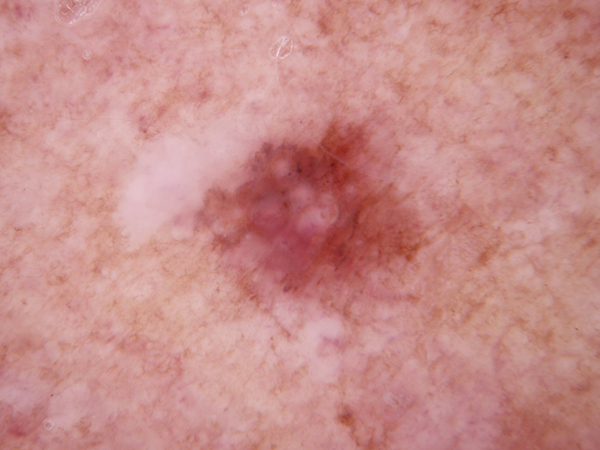

In [15]:
import PIL
PIL.Image.open(str(train_data_frame['filename'][1]))

Found 1 validated image filenames belonging to 1 classes.


C:\Users\Mahmoud S.AbdelRahma\AppData\Local\Temp\ipykernel_17344\2866951001.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


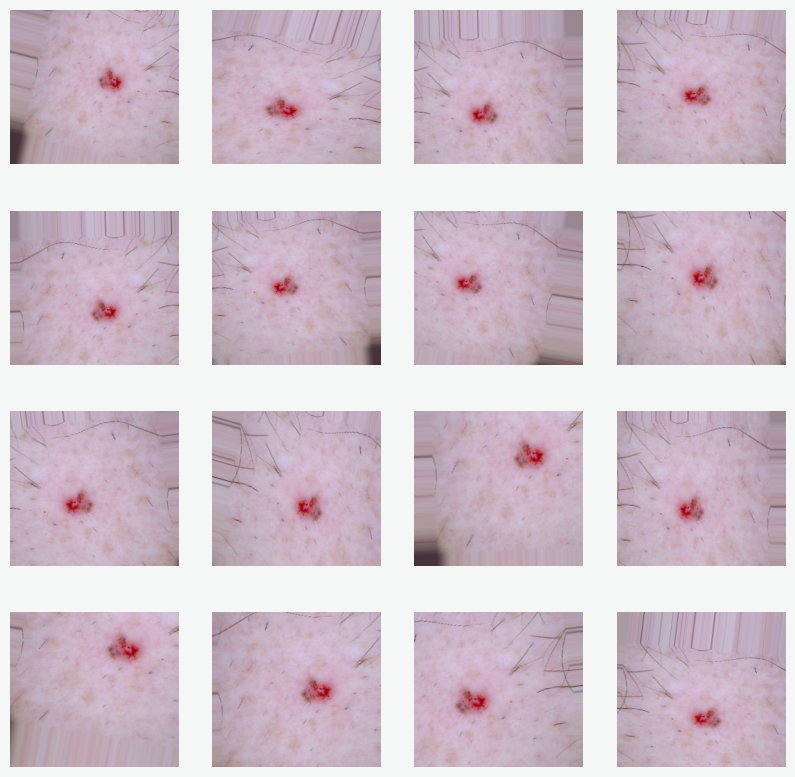

In [16]:
import matplotlib.pyplot as plt
def data_argumentation_show(n, grid_size):

    sample_data = train_datagen.flow_from_dataframe(
            (train_df.sample(n)),
           
            x_col = 'filename',
            y_col = 'category',
            target_size = (224, 244),
            class_mode = 'categorical')
  
  #subplot grid 
    fig = plt.figure(figsize = (10,10))
    fig.patch.set_facecolor('#f5f6f6')
    for i in range(0,grid_size*grid_size):
        plt.subplot(grid_size,grid_size, i+1)
        for x,y in sample_data:
            img = x[0]
            plt.imshow(img)
            plt.axis('off')
            break
            plt.tight_layout()
            del img
    fig.show()
data_argumentation_show(1,4)


In [17]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D,GlobalAveragePooling2D
from keras import applications
from keras import optimizers
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model


In [18]:


image_size = 224
input_shape = (image_size, image_size, 3)



pre_trained_model = InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')
    
pre_trained_model.trainable = False

add_model = Sequential()
add_model.add(pre_trained_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(len(classes), 
                    activation='softmax'))

model = add_model

model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.SGD(learning_rate=1e-4, #0.0001
                                       momentum=0.9),
              metrics=['accuracy'])
model.summary()


87910968/87910968 [==============================] - 155s 2us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 9)                 18441     
                                                                 
Total params: 21,821,225
Trainable params: 18,441
Non-trainable params: 21,802,784
_________________________________________________________________


In [19]:
history1 = model.fit_generator(
    train_generator,
    epochs=2,# <----- increase it for 20
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    
)

C:\Users\Mahmoud S.AbdelRahma\AppData\Local\Temp\ipykernel_17344\2802655077.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model.fit_generator(


Epoch 1/2
111/111 [==============================] - 88s 734ms/step - loss: 2.5076 - accuracy: 0.1690 - val_loss: 2.0448 - val_accuracy: 0.2589
Epoch 2/2
111/111 [==============================] - 32s 284ms/step - loss: 2.3062 - accuracy: 0.2146 - val_loss: 1.9363 - val_accuracy: 0.2679


data\Test\actinic keratosis\ISIC_0010512.jpg
[[[ 99 117 146]
  [ 98 116 145]
  [ 95 116 144]
  ...
  [111 123 159]
  [111 122 160]
  [109 122 160]]

 [[102 120 149]
  [100 118 147]
  [ 97 118 146]
  ...
  [113 122 159]
  [111 122 160]
  [109 122 160]]

 [[101 119 148]
  [100 118 147]
  [ 97 118 146]
  ...
  [113 122 159]
  [111 123 159]
  [111 123 159]]

 ...

 [[ 79  99 140]
  [ 78  98 139]
  [ 79  98 136]
  ...
  [114 116 151]
  [113 115 150]
  [112 114 149]]

 [[ 79  99 140]
  [ 79  99 140]
  [ 77  97 138]
  ...
  [113 115 150]
  [112 114 149]
  [111 113 148]]

 [[ 79  99 140]
  [ 79  99 140]
  [ 79  99 140]
  ...
  [111 113 148]
  [110 112 147]
  [109 111 146]]]


NameError: name 'model' is not defined

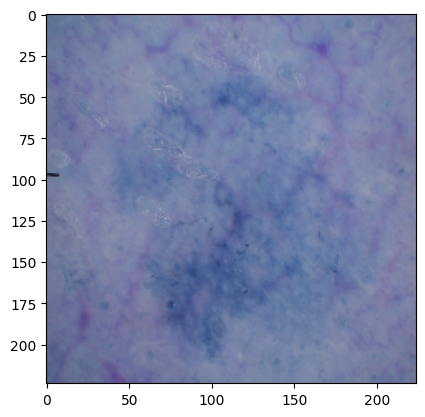

In [1]:
import cv2
import matplotlib.pylab as plt
def pip_line(image_path):
    image=cv2.imread(str(image_path))
    imageee=cv2.resize(image,(224,224))
    imageee=imageee/255.0
    plt.imshow(imageee)
    res= model.predict(np.array([imageee]))
    return le.classes_[np.argmax(res)] 
print(pip_line(r'data\Test\actinic keratosis\ISIC_0010512.jpg'))